In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a descompose a covariance matrix with the spectral theorem and then we train a convolutional autoencoter to learn to generate fake covariance matrices. 

#### First, we need to read the data. In this case, we use the covariance matrix of systematic erros from Pantheon compilation of SN-1a 

In [2]:
syscov = np.loadtxt('https://raw.githubusercontent.com/ja-vazquez/SimpleMC/master/simplemc/data/pantheon_sys_full_long.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

3

### Visualization of the covariance matrix:

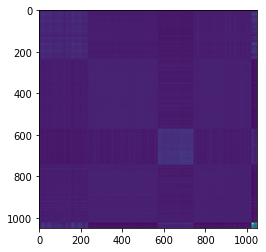

In [4]:
plt.imshow(syscov)

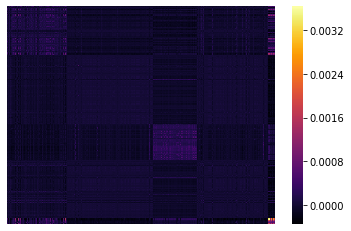

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')


In [6]:
np.min(syscov.diagonal()) #checking non-negatives in the diagonal

3.5145e-05

### Use matrix descomposition (spectral theorem)

### $\Sigma = P D P^T$

#### where P is an orthogonal matrix with the eigenvectors from $\Sigma$ and D a diagonal matrix with its eigenvalues.

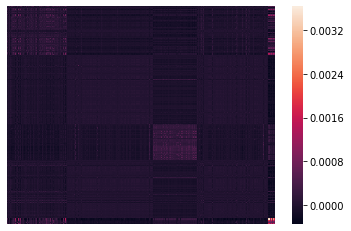

In [7]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
D, P = sp.linalg.eigh(syscov)
D = np.diag(D)
rec_cov = P @ D @ P.T
sns.heatmap(pd.DataFrame(rec_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, )

#### Checking that there are not complex values

In [8]:
count = 0

for i in range(len(P)):
    for j in range(len(P)):
        if np.iscomplex(P[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


### Visualization of the eigenvector matrix $P$

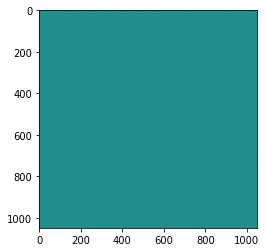

In [9]:
plt.imshow(P)

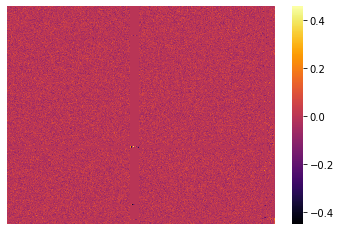

In [10]:
sns.heatmap(pd.DataFrame(P), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

### Generate a data set with matrices of eigenvectors from the original plus gaussian noise

In [11]:
numMatrix = 50
noise_factor = 1e-5
maxval = np.max(P)
Pscaled = P / maxval
pset = np.zeros((numMatrix, 1048, 1048))
for i in range(numMatrix): 
    pset[i] = Pscaled + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=P.shape) 

In [12]:
print(np.shape(pset))

(50, 1048, 1048)


(50, 1048, 1048)
(10, 1048, 1048) (40, 1048, 1048)


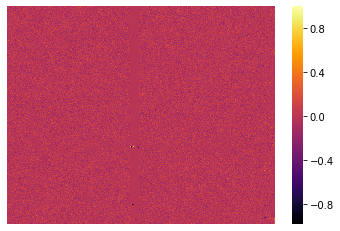

In [13]:
print(np.shape(pset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
pset_train, pset_test = np.split(pset, indx, axis=0)
print(np.shape(pset_test), np.shape(pset_train))
sns.heatmap(pd.DataFrame(pset_test[0, :, :]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [14]:

input_cov = Input(shape=(1048, 1048, 1))

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(input_cov)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoded = Dense(1048)(x)
x = Dense(131*131*2)(encoded)
x = layers.Reshape((131,131,2))(x)

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = tf.keras.Model(input_cov, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1048, 1048, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1048, 1048, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 524, 524, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 524, 524, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 262, 262, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 262, 262, 2)       74        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 131, 131, 2)      

In [31]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=10,
                                   restore_best_weights=True)]
autoencoder_train = autoencoder.fit(pset_train, pset_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(pset_test, pset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 2/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 3/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 4/200
2/2 [==============================] - 4s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 5/200
2/2 [==============================] - 5s 3s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 6/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 7/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 8/200
2/2 [==============================] - 4s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 9/200
2/2 [==============================] - 4s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/200
2/2 [==============================] - 4s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 11/200
2/2 [=====================

2/2 [==============================] - 5s 3s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 86/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 87/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 88/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 89/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 90/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 91/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 92/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 93/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 94/200
2/2 [==============================] - 5s 2s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 95/200
2/2 [=========================

Epoch 169/200
2/2 [==============================] - 7s 3s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 170/200
2/2 [==============================] - 7s 3s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 171/200
2/2 [==============================] - 6s 3s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 172/200
2/2 [==============================] - 7s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 173/200
2/2 [==============================] - 8s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 174/200
2/2 [==============================] - 8s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 175/200
2/2 [==============================] - 8s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 176/200
2/2 [==============================] - 7s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 177/200
2/2 [==============================] - 9s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 178/200
2/2 [==============================] - 9s 4s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 179/200
2/2 [=

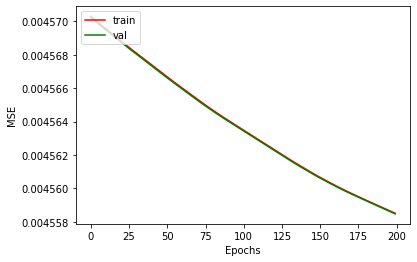

In [32]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [33]:
print(np.shape(pset_test))
decoded_imgs = autoencoder.predict(pset_test)
decoded_imgs[0, :, :, 0]

(10, 1048, 1048)


array([[-0.00070799, -0.00060131, -0.00060154, ..., -0.00070732,
        -0.00067477, -0.00060484],
       [-0.00057999, -0.00062825, -0.00062794, ..., -0.00072952,
        -0.00069077, -0.00071518],
       [-0.00056894, -0.00062441, -0.0006287 , ..., -0.00053145,
        -0.00053954, -0.00080532],
       ...,
       [-0.00059214, -0.00069131, -0.00058349, ..., -0.00061364,
        -0.00063034, -0.00073213],
       [-0.00058594, -0.00035464, -0.00035874, ..., -0.00070568,
        -0.00070792, -0.00078463],
       [-0.00073141, -0.00067344, -0.00068013, ..., -0.00069299,
        -0.00069526, -0.00068345]], dtype=float32)

(10, 1048, 1048, 1)
(10, 1048, 1048, 1)


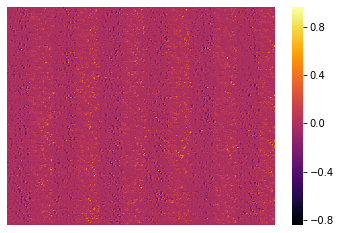

In [48]:
print(np.shape(decoded_imgs))
# plt.imshow(decoded_imgs[3, : , :, 0])
print(np.shape(decoded_imgs))
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]*maxval*100/2), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [35]:
print(np.shape(decoded_imgs))

(10, 1048, 1048, 1)


(10, 1048, 1048)


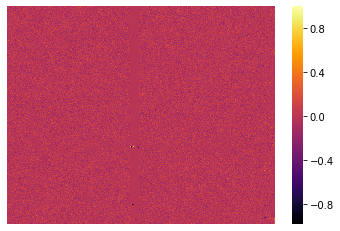

In [36]:
print(np.shape(pset_test))
# plt.imshow(evec_test[3, : , :])
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[0, :, :])),
sns.heatmap(pd.DataFrame(pset_test[0, :, :]),
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

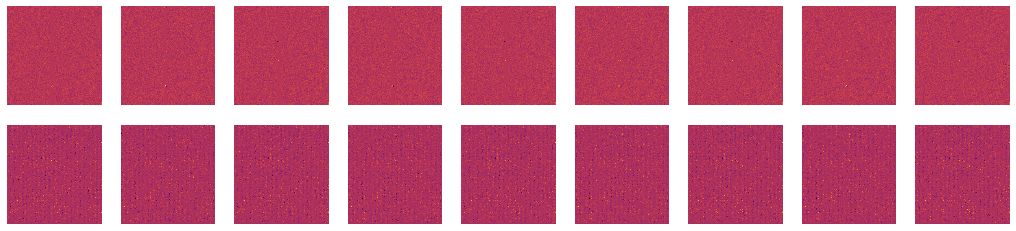

In [37]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[i, :, :])), 
    sns.heatmap(pd.DataFrame(pset_test[i, :, :]), 
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=False, cbar=False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    sns.heatmap(pd.DataFrame(decoded_imgs[i, :, :, 0]*maxval),
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=False, cbar=False)

plt.show()

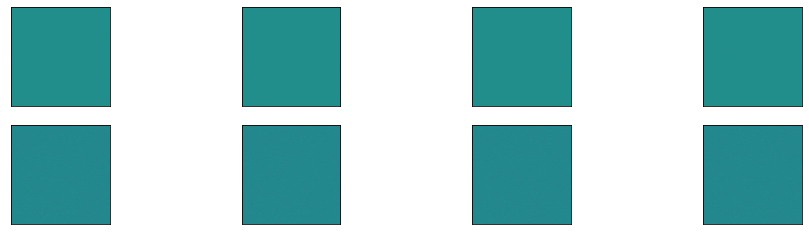

In [38]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     plt.imshow(scaler.inverse_transform(evec_test[i, :, :]))
    plt.imshow(pset_test[i, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i, :, :, 0]*maxval)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [39]:
# print(np.min(scaler.inverse_transform(evec_test[0, :, :])), np.min(decoded_imgs[0, :, :, 0]))
print(np.min(pset_test[0, :, :]), np.min(decoded_imgs[0, :, :, 0]))

-0.9787208383614877 -0.036657907


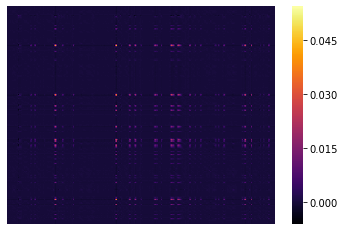

In [49]:
pprima = decoded_imgs[0,:,:,0] *maxval*100/2
new_matrix = pprima @ D @ pprima.T

sns.heatmap(pd.DataFrame(new_matrix),
            xticklabels=False, yticklabels=False, 
            cmap = 'inferno', fmt='g',
            robust=False)